In [1]:
import graphviz

# Splay Trees

In diesem Notebook wird eine bestimmte Art von selbstbalancierenden Bäumen gezeigt, die *Splay Trees*. Diese Datenstruktur wurde 1985 von Sleator und Tarjan eingeführt **cit**. Im Gegensatz zu anderen selbstbalancierenden Bäumen wie *AVL-Bäumen* wird bei Splay Trees nicht gefordert, dass der Baum zu allen Zeiten so gut wie möglich balanciert ist. Stattdessen wird der Baum dahingehend optimiert, dass häufig verwendete Elemente nahe an der Wurzel sind.

Auf Basis dieser Bäume soll später eine alternative Implementierung von Mengen in der Programmiersprache Python entstehen. In Python, wie in vielen anderen Implementierungen verschiedener Programmiersprachen **cit**, sind Mengen normalerweise auf Basis von *Hashtabellen* implementiert **cit**.

Die reine Datenstruktur – ohne Operationen – ist bei Splay Trees genauso wie bei regulären geordneten binären Bäumen definiert:

- $Nil$ ist der leere Baum.
- $Node(p, l, r)$ ist ein Baum, wobei
  - $p$ eine Nutzlast (payload) ist,
  - $l$ der linke Teilbaum ist und
  - $r$ der rechte Teilbaum ist.

Wir erleichtern uns die Definitionsarbeit für Methoden, indem wir für den leeren Baum statt `Nil` einen Knoten mit der Nutzlast `Nil` setzen. Zu diesem Zeitpunkt müssen wir alle Methodenrümpfe, die später verwendet werden, deklarieren. Später folgen die eigentlichen Definitionen dieser Methoden.

In [2]:
class Nil:
    pass


class Node:
    def __init__(self, payload=Nil(), left=None, right=None):
        self.payload = payload
        self.left = left
        self.right = right
    
    def _splay(self, parent_stack, direction_stack):
        pass
    
    # have all in _splay later
    # just for demonstration
    # let "zig" be left, "zag" be right
    # order: top down
    def zig(self, parent):
        pass
    
    def zag(self, parent):
        pass
    
    def zig_zig(self, parent, grandparent):
        pass
    
    def zag_zag(self, parent, grandparent):
        pass
    
    def zig_zag(self, parent, grandparent):
        pass
    
    def zag_zig(self, parent, grandparent):
        pass
    
    def insert(self, payload):
        pass
    
    def delete(self, payload):
        pass
    
    def contains(self, payload):
        # should be infix `in` later
        pass
    
    def show(self):
        pass
    
    def _show(self, dot, used, key):
        pass

Wir verlangen dabei:

- Für alle Nutzlasten aus dem linken Teilbaum $l$ gilt, dass sie kleiner als die Nutzlast $p$ sind.
- Für alle Nutzlasten aus dem rechten Teilbaum $r$ gilt, dass sie größer als die Nutzlast $p$ sind.

Diese Aussagen können auch als $l < p < r$ formuliert werden.

Die Betrachtung des Falls, dass eine Nutzlast in einem Teilbaum $l, r$ gleich der Nutzlast $p$ ist, entfällt, da Mengen keine doppelten Elemente enthalten. Diese Forderung impliziert außerdem, dass die Nutzlasten geordnet werden können. Wir behandeln später, wie wir beliebigen Nutzlasten in Python eine Ordnung geben können.

Wir definieren zunächst die Methode `show`, die einen Baum auf Basis von *GraphViz* visualisiert. Dies erleichtert später die Erklärungen anderer Operationen. `show` benutzt `_show`, eine Methode, die einem bestehenden Graphen die Knoten hinzufügt. `_show` nimmt zusätzlich eine Menge von benutzten Schlüsseln für die Knoten und einen Zähler, der Schlüssel für leere Blätter im Baum liefert.

In [3]:
def show(self):
    dot = graphviz.Digraph()
    if isinstance(self.payload, Nil):
        dot.node("", shape="point")
    else:
        self._show(dot, set(), 0)
    return dot

def _show(self, dot, used, key):
    used.add(id(self))
    dot.node(str(id(self)), label=str(self.payload))
    if not (self.left is None and self.left is None):
        for node in self.left, self.right:
            if node is not None:
                dot.edge(str(id(self)), str(id(node)))
                used, key = node._show(dot, used, key)
            else:
                while True:
                    key += 1
                    if key not in used:
                        break
                used.add(key)
                dot.node(str(key), shape="point")
                dot.edge(str(id(self)), str(key))
    return (used, key)

Node.show = show
Node._show = _show
show = None
_show = None

## Splaying

Die Besonderheit von Splay Trees ist, dass nach allen Baumoperationen, die ein Element im Baum lokalisieren, eine besondere Operation, der *Splay*, durchgeführt wird. Mit Baumoperationen, die ein Element im Baum lokalisieren, sind alle Operationen auf den Baum gemeint, die den Baum auf der Suche nach einem Element oder auf der Suche nach dem richtigen Ort für ein Element durchsuchen. Dazu gehören das Einfügen, Löschen und Finden von Elementen.

Der Splay ist eine Funktion, die einen Baum dahingehend modifiziert, dass ein Knoten, der schon im Baum enthalten ist, die neue Wurzel des Baums wird:

$$splay: Node \times Node \to Node$$

Der Splay findet schrittweise statt, in jedem Schritt wird der zu splayende Knoten zwei Ebenen nach oben bewegt. Sollte der Knoten auf der zweitobersten Ebene sein, so wird er natürlich nur eine Ebene nach oben bewegt. Diesen Schritt behandeln wir zuerst. Ist der Knoten dabei das linke Kind seines Elternknotens, so bezeichnen wir diesen Schritt als *Zig*.

### Zig und Zag

Vor dem Schritt sieht der Baum wie folgt aus. Die Dreiecke zeigen dabei Teilbäume an.

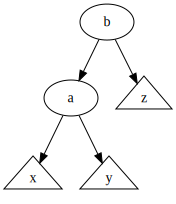

In [4]:
x = Node("x", None, None); y = Node("y", None, None); z = Node("z", None, None)
a = Node("a", x, y); b = Node("b", a, z)
dot = b.show()
for subtree in x, y, z:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir bewegen den Knoten $a$ an die Wurzel, wobei $b$ das rechte Kind von $a$ wird, und der ehemals rechte Teilbaum von $a$, $y$, nun der linke Teilbaum von $b$ wird. Die Ordnung wird dabei nicht verletzt, denn

- $x$, $z$ sind weiterhin die gleichen Teilbäume ihrer bisherigen Eltern,
- $a < b$ und
- $y < b$ und $y > a$.

Formal definieren wir $zig()$ unter der Angabe des Elternknotens als Parameter als

$$Node(a, x, y).zig(Node(b, \_, z)) = Node(a, x, Node(b, y, z))$$

und in Code als

In [5]:
def zig(self, parent):
    parent.left = self.right
    self.right = parent

Node.zig = zig
zig = None

Nach dem Schritt sieht der Baum wie folgt aus:

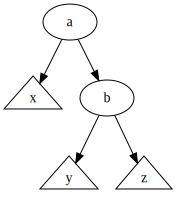

In [6]:
a.zig(b)
dot = a.show()
for subtree in x, y, z:
    dot.node(str(id(subtree)), shape="triangle")
dot

Ähnlich definieren wir *Zag*, bei dem der zu splayende Knoten das rechte Kind der Wurzel ist.

$$Node(a, y, z).zag(Node(b, x, \_) = Node(a, Node(b, x, y), z)$$

In [7]:
def zag(self, parent):
    parent.left = self.right
    self.right = parent

Node.zag = zag
zag = None

### Zig-Zig und Zag-Zag

Als nächstes behandeln wir den Fall, dass der Knoten wenigstens zwei Ebenen von der Wurzel entfernt ist, und sowohl der Knoten als auch sein Elternknoten ein linkes Kind sind. Die Operation, die auf diese Ausgangssituation anzuwenden ist, bezeichnen wir als *Zig-Zig*. Diese Ausgangssituation sieht so aus:

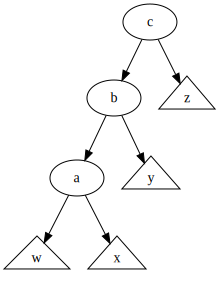

In [8]:
w = Node("w", None, None); x = Node("x", None, None); y = Node("y", None, None); z = Node("z", None, None)
a = Node("a", w, x); b = Node("b", a, y); c = Node("c", b, z)
dot = c.show()
for subtree in w, x, y, z:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir bewegen den Knoten $a$ an die Stelle von $c$. Infolgedessen wird $b$ das linke Kind von $a$ und $c$ das linke Kind von $b$. $x$ wird der linke Teilbaum von $b$, $y$ der linke Teilbaum von $c$. Die Ordnungsbedingung bleibt erhalten:

- $w$, $z$ sind weiterhin die gleichen Teilbäume ihrer bisherigen Eltern,
- $a < b < c$ und
- $a < x < b$ und $b < y < c$.

Wir definieren unter Angabe von Elternknoten und Großelternknoten

$$Node(a, w, x).zig\_zig(Node(b, \_, y), Node(c, \_, z)) = Node(a, w, Node(b, x, Node(c, y, z)))$$

und in Code

In [9]:
def zig_zig(self, parent, grandparent):
    grandparent.left = parent.right
    parent.left = self.right
    parent.right = grandparent
    self.right = parent

Node.zig_zig = zig_zig
zig_zig = None

und haben visualisiert

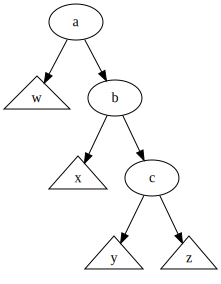

In [10]:
a.zig_zig(b, c)
dot = a.show()
for subtree in w, x, y, z:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir bezeichnen die gleiche Situation mit rechtem Kind und rechtem Enkel als *Zag-Zag*. Der Splay-Schritt ist ähnlich definiert.

$$Node(a, y, z).zag\_zag(Node(b, x, \_), Node(c, w, \_)) = Node(a, Node(b, Node(c, w, x), y), z)$$

In [11]:
def zag_zag(self, parent, grandparent):
    grandparent.right = parent.left
    parent.left = grandparent
    parent.right = self.left
    self.left = parent

Node.zag_zag = zag_zag
zag_zag = None

### Zig-Zag und Zag-Zig

Zuletzt behandeln wir den Fall, dass der Elternknoten ein linkes Kind, der Knoten selbst aber ein rechtes Kind ist. Die Operation auf diese Situation nennen wir *Zig-Zag*. Wir beginnen mit

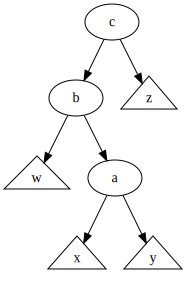

In [12]:
w = Node("w", None, None); x = Node("x", None, None); y = Node("y", None, None); z = Node("z", None, None)
a = Node("a", x, y); b = Node("b", w, a); c = Node("c", b, z)
dot = c.show()
for subtree in w, x, y, z:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir bewegen den Knoten $a$ an die Stelle von $c$, dabei werden $b, c$ die Kinder von $a$. $x$ wird der rechte Teilbaum von $b$, $y$ der linke Teilbaum von $c$. Die Ordnungsbedingung bleibt erhalten:

- $w, z$ sind weiterhin die gleichen Teilbäume ihrer bisherigen Eltern,
- $b < a < c$ und
- $b < x < a$ und $a < y < c$.

Wir definieren

$$Node(a, x, y).zig\_zag(Node(b, w, \_), Node(c, \_, z)) = Node(a, Node(b, w, x), Node(c, y, z))$$

und in Code

In [15]:
def zig_zag(self, parent, grandparent):
    parent.right = self.left
    grandparent.left = self.right
    self.left = parent
    self.right = grandparent

Node.zig_zag = zig_zag
zig_zag = None

und haben visualisiert

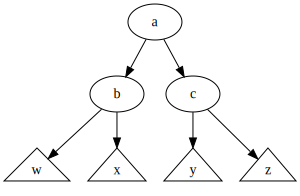

In [16]:
a.zig_zag(b, c)
dot = a.show()
for subtree in w, x, y, z:
    dot.node(str(id(subtree)), shape="triangle")
dot

In umgekehrter Reihenfolge, d.h. der Elternknoten ist das rechte Kind, der Knoten das linke Kind, haben wir die Operation *Zag-Zig* mit

$$Node(a, x, y).zag\_zig(Node(b, \_, z), Node(c, w, \_)) = Node(a, Node(c, w, x), Node(b, y, z))$$

In [17]:
def zag_zig(self, parent, grandparent):
    grandparent.right = self.left
    parent.left = self.right
    self.left = grandparent
    self.right = parent

Node.zag_zig = zag_zig
zag_zig = None